<a href="https://www.kaggle.com/code/jiyoung37/customer-segmentation-byrfm?scriptVersionId=232408856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing necessary libraries

In [1]:
import numpy as np                                # For numerical operations and handling arrays
import pandas as pd                               # For data manipulation and analysis
import seaborn as sns                             # For statistical data visualization (e.g., heatmaps)
import matplotlib.pyplot as plt                   # For visualizing data
from sklearn.preprocessing import MinMaxScaler    # For scaling the data (Min-Max)
from sklearn.preprocessing import StandardScaler  # For scaling the data (Standardization)
from sklearn.cluster import KMeans                # For K-Means clustering
from sklearn.cluster import DBSCAN                # For DBSCAN clustering
from sklearn.metrics import silhouette_score      # For evaluating clustering performance
from sklearn.manifold import TSNE                 # For dimensionality reduction (t-SNE)
from sklearn.decomposition import PCA
import os   

# Data preparation

In [2]:
# Loop through all files in the input directory and get their paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_Path = os.path.join(dirname, filename)  # Construct and Storing full path of the Excel file

In [3]:
# Reading the Excel file
df = pd.read_excel(file_Path)              
# Displaying the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Overview

In [4]:
# data shape
print("data shape:",df.shape)

data shape: (541909, 8)


In [5]:
# missing data
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# Data cleaning

From database summary, it was observed:

a. The minimum values should not be negative.

b. The maximum values are far higher than median.

This indicates the presence of extreme outliers that require correction.

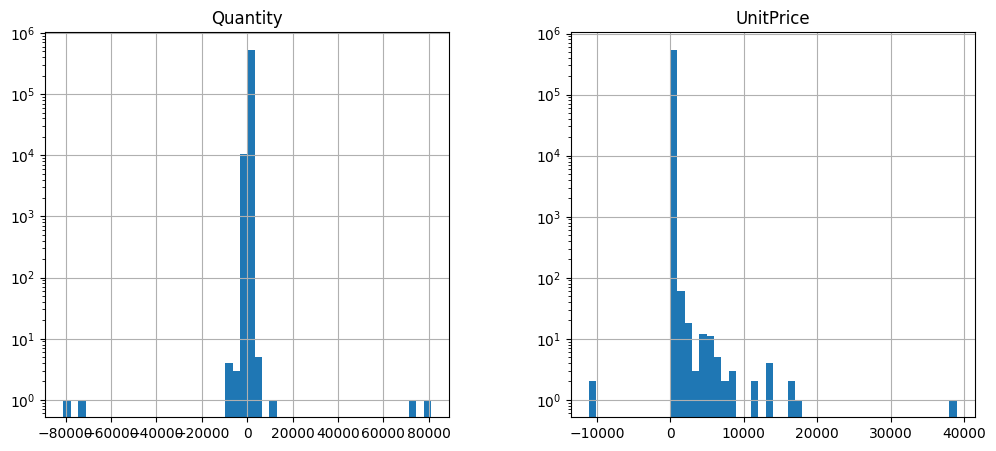

In [8]:
df[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
plt.show()

## Option 1_Qauantity, UnitPrice: value range cleaning

Remove all negatie values

In [9]:
# Identify rows with negative values
negative_values = df[(df['Quantity'] < 0) | (df['UnitPrice'] < 0)]

print(f"Quantity-number of negative rows: {df[df['Quantity']<0].shape[0]}")
print(f"UnitPrice--number of negative rows: {df[df['UnitPrice']<0].shape[0]}")

Quantity-number of negative rows: 10624
UnitPrice--number of negative rows: 2


In [10]:
# Drop rows with negative values
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104,530104.000000,397884.000000
mean,10.542037,2011-07-04 20:16:05.225088,3.907625,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:22:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:58:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:39:00,4.130000,16795.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,155.524124,NaN,35.915681,1713.141560


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


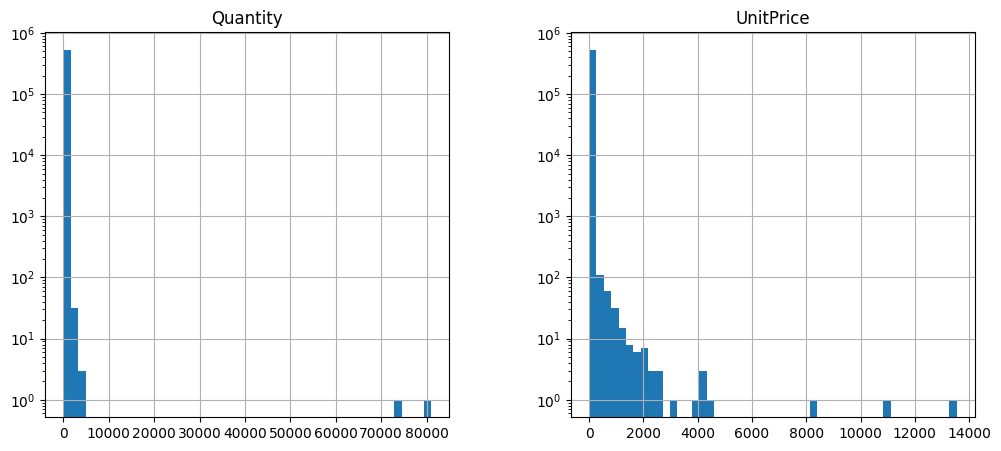

In [12]:
df[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
plt.show()

## Option 2_Qauantity, UnitPrice: value range cleaning

Remove outliers by applying Interquartile Range (IQR) method

In [13]:
# Function: outlier remove
# def remove_outliers_iqr(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

# # Quantity outlier remove
# df = remove_outliers_iqr(df, 'Quantity')

# # UnitPrice outlier remove
# df = remove_outliers_iqr(df, 'UnitPrice')

# df[['Quantity', 'UnitPrice']].describe()

In [14]:
# print(df[['Quantity', 'UnitPrice']].describe())

# df[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
# plt.show()

# Feature engeneering: add column

In [15]:
# Create Total_Price column
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

In [16]:
# Creat Month column
df['Month'] = df['InvoiceDate'].dt.month
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12


# Data Visualization and Insights

## 1. Plot montly total sales trend

In [17]:
monthly_sales = df.groupby('Month')['Total_Price'].sum()
monthly_sales

Month
1      691364.560
2      523631.890
3      717639.360
4      537808.621
5      770536.020
6      761739.900
7      719221.191
8      759138.380
9     1058590.172
10    1154979.300
11    1509496.330
12    1462538.820
Name: Total_Price, dtype: float64

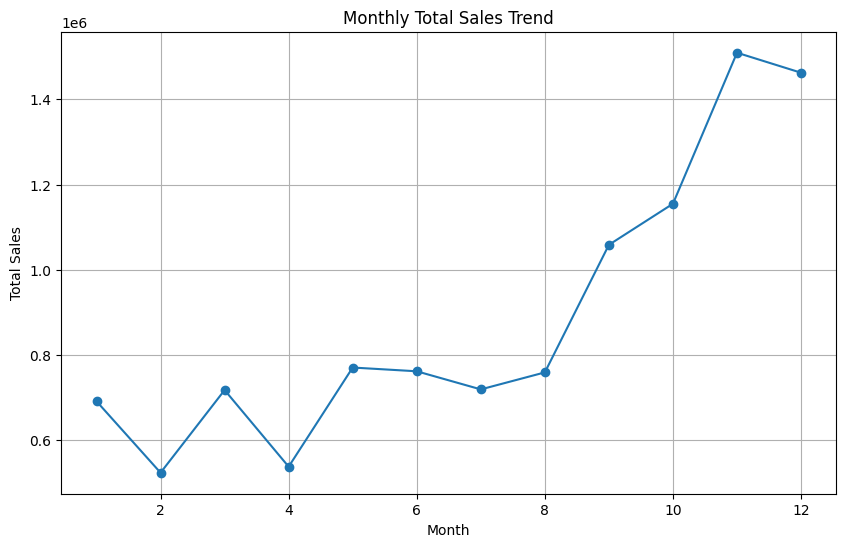

In [18]:
monthly_sales.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Monthly Total Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

## Insights
Total sales increases from August and show a peek in November. This is likely due to the christmas holiday season.

## 2. Top 5 countries based on total sales

In [19]:
top_5_countries = df.groupby('Country')['Total_Price'].sum().sort_values(ascending=False).head(5)
top_5_countries.head()

Country
United Kingdom    9025222.084
Netherlands        285446.340
EIRE               283453.960
Germany            228867.140
France             209715.110
Name: Total_Price, dtype: float64

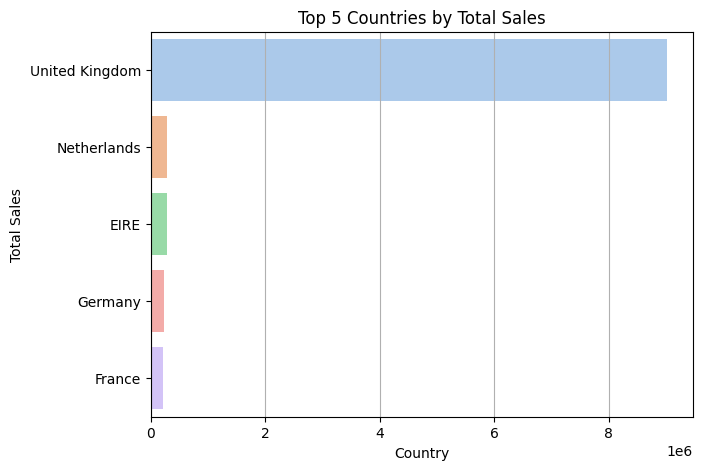

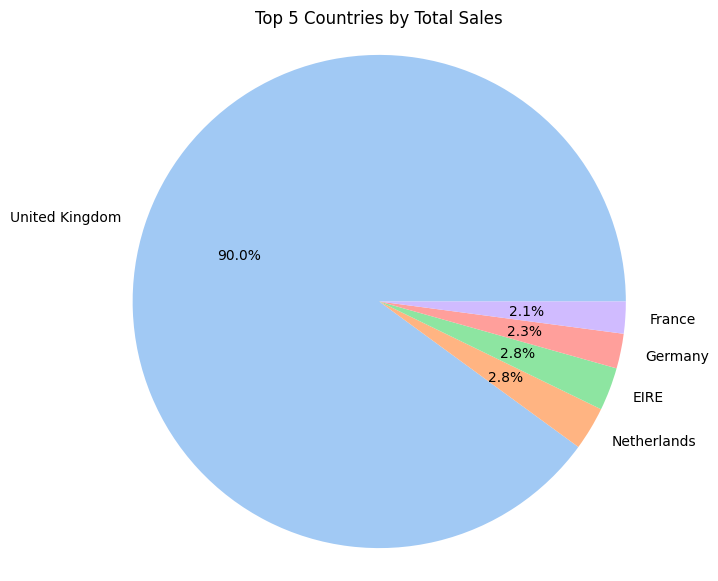

In [20]:
colors = sns.color_palette("pastel", n_colors=5)

# Creat barchart
plt.figure(figsize=(7, 5))
sns.barplot(y=top_5_countries.index, x=top_5_countries.values, palette="pastel")

plt.title('Top 5 Countries by Total Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.grid(axis='x');

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(top_5_countries.values, labels=top_5_countries.index, autopct='%1.1f%%', colors=colors)
plt.title('Top 5 Countries by Total Sales')
plt.axis('equal');

## Insights
1. UK Dominates Sales (92% among Top 5 Countries)

- The United Kingdom contributes the majority of sales, making it the primary focus for customer care and retention strategies.
- Ensuring high customer satisfaction and loyalty in the UK should be a priority.

2. Expansion Strategy

- For future growth, expanding sales in other countries is essential.
- Instead of starting from scratch, we can leverage existing markets.
- Germany, France, and EIRE (ranked 2nd to 4th) should be our initial expansion targets, as they already have a customer base.

## 3. Top 5 products based on total sales

In [21]:
top_5_products = df.groupby('StockCode')['Total_Price'].sum().sort_values(ascending=False).head(5)
top_5_products

StockCode
DOT       206248.77
22423     174484.74
23843     168469.60
85123A    104518.80
47566      99504.33
Name: Total_Price, dtype: float64

In [22]:
df[df['StockCode'] == "DOT"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Price,Month
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom,569.77,12
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom,607.49,12
5450,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,NaN,United Kingdom,254.43,12
5545,536864,DOT,DOTCOM POSTAGE,1,2010-12-03 11:27:00,121.06,NaN,United Kingdom,121.06,12
5685,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,NaN,United Kingdom,498.47,12
...,...,...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,NaN,United Kingdom,1008.96,12
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,NaN,United Kingdom,1683.75,12
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,NaN,United Kingdom,938.59,12
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,NaN,United Kingdom,933.17,12


In [23]:
description = df.groupby('StockCode')['Description'].apply(lambda x: x.mode()[0]).to_dict()

# Extract descriptions for the top 5 products
top_5_descriptions= {stock_code: description.get(stock_code, "Description not found") for stock_code in top_5_products.index}

# Print results
for stock_code, description in top_5_descriptions.items():
    print(f"{stock_code} = {description}")

DOT = DOTCOM POSTAGE
22423 = REGENCY CAKESTAND 3 TIER
23843 = PAPER CRAFT , LITTLE BIRDIE
85123A = WHITE HANGING HEART T-LIGHT HOLDER
47566 = PARTY BUNTING


# RFM analysis
1. Recency: How recently the customer made a purchase

2. Frequency: How often the customer makes a purchase

3. Monetary: How much the customer spends

In [24]:
# Reference date for recency calculation
reference_date = df['InvoiceDate'].max()

# Creating new DataFrame, grouping by CustomerID and calculating RFM metrics
df_rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)
    'InvoiceNo': 'count',                                      # Frequency (number of transactions)
    'Total_Price': 'sum'                                       # Monetary (total money spent)
})

# Rename columns for clarity
df_rfm = df_rfm.rename(columns={
    'InvoiceDate': 'Recency',      # Renaming InvoiceDate column as Recency
    'InvoiceNo': 'Frequency',      # Renaming InvoiceNo column as Frequency
    'Total_Price': 'Monetary'      # Renaming Total_Price column as Monetary
})

# Display the first few rows of the RFM DataFrame
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


In [25]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,91.536422,91.720609,2054.266460
std,100.014169,228.785094,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,307.415000
50%,50.000000,41.000000,674.485000
75%,141.000000,100.000000,1661.740000
max,373.000000,7847.000000,280206.020000


In [26]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


# Segment Customers based on RFM

In [27]:
df_rfm_seg = df_rfm.copy()

df_rfm_seg['R_seg'] = pd.qcut(df_rfm_seg['Recency'], q=4, labels=[4, 3, 2, 1])
df_rfm_seg['F_seg'] = pd.qcut(df_rfm_seg['Frequency'], q=4, labels=[1, 2, 3, 4])
df_rfm_seg['M_seg'] = pd.qcut(df_rfm_seg['Monetary'], q=4, labels=[1, 2, 3, 4])

df_rfm_seg['RFM_score'] = df_rfm_seg[['R_seg','F_seg','M_seg']].sum(axis=1)

df_rfm_seg.head()

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,6
12347.0,1,182,4310.00,4,4,4,12
12348.0,74,31,1797.24,2,2,4,8
12349.0,18,73,1757.55,3,3,4,10
12350.0,309,17,334.40,1,1,2,4


In [28]:
# Customer with highest RFM scores
df_rfm_seg.sort_values('RFM_score', ascending=False).head()

,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score
CustomerID,,,,,,,
18198.0,3,159,5425.56,4,4,4,12
18210.0,1,134,2621.38,4,4,4,12
18225.0,2,271,5509.12,4,4,4,12
18283.0,3,756,2094.88,4,4,4,12
16983.0,12,148,1931.25,4,4,4,12


In [29]:
# Extract country information of CustomerID
df_customer_country = df[['CustomerID','Country']].drop_duplicates()

# Merge to df_rfm_seg
df_rfm_seg_country=df_rfm_seg.merge(df_customer_country, on='CustomerID', how='left')

df_rfm_seg_country.head()

,CustomerID,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Country
0,12346.0,325,1,77183.60,1,1,4,6,United Kingdom
1,12347.0,1,182,4310.00,4,4,4,12,Iceland
2,12348.0,74,31,1797.24,2,2,4,8,Finland
3,12349.0,18,73,1757.55,3,3,4,10,Italy
4,12350.0,309,17,334.40,1,1,2,4,Norway


In [30]:
# Saving preprocessed dataset
df_rfm.to_csv('df_rfm.csv', index=False)
df_rfm_seg.to_csv('df_rfm_seg.csv', index=False)
df_rfm_seg_country.to_csv('df_rfm_seg_country.csv', index=False)

# Data analysis

## Segmentation results

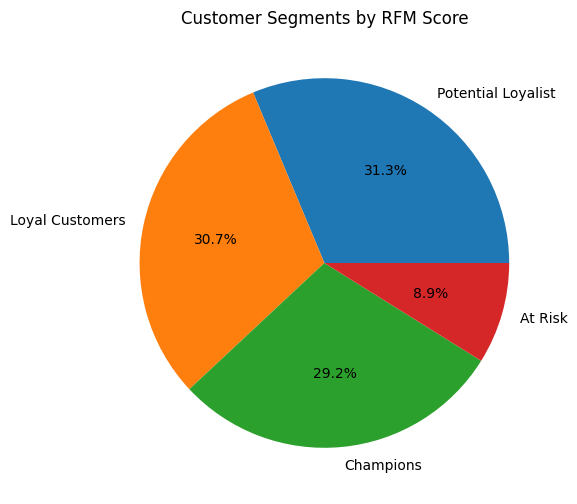

In [31]:
# Create RFM segment labels (example)
def segment_customer(row):
    if row['RFM_score'] >= 10:
        return 'Champions'
    elif row['RFM_score'] >= 7:
        return 'Loyal Customers'
    elif row['RFM_score'] >= 4:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

df_rfm_seg['Segment'] = df_rfm_seg.apply(segment_customer, axis=1)

# Plot
df_rfm_seg['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title("Customer Segments by RFM Score")
plt.ylabel('')
plt.show()


In [32]:
top_customers = df_rfm_seg_country.sort_values('RFM_score', ascending=False).head(10)
top_customers = top_customers[['CustomerID', 'Country', 'RFM_score', 'Monetary', 'Frequency', 'Recency']]

top_customers.columns = ['Customer ID', 'Country', 'RFM Score', 'Total Spend (€)', 'Purchase Count', 'Days Since Last Purchase']

# Format Monetary column
top_customers['Total Spend (€)'] = top_customers['Total Spend (€)'].map('{:,.2f}'.format)

top_customers.head(10)

,Customer ID,Country,RFM Score,Total Spend (€),Purchase Count,Days Since Last Purchase
111,12474.0,Germany,12,"7,375.79",424,16
4301,18225.0,United Kingdom,12,"5,509.12",271,2
3038,16474.0,United Kingdom,12,"1,871.50",360,6
108,12471.0,Germany,12,"19,824.05",460,1
2998,16422.0,United Kingdom,12,"34,684.40",369,16
4317,18245.0,United Kingdom,12,"2,567.06",175,6
77,12433.0,Norway,12,"13,375.87",420,0
65,12423.0,Belgium,12,"1,859.31",125,0
4287,18210.0,United Kingdom,12,"2,621.38",134,1
4280,18198.0,United Kingdom,12,"5,425.56",159,3


<ipython-input-33-0e91c9b4d730>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_pivot = df_rfm_seg_country.pivot_table(index='R_seg', columns='F_seg', values='CustomerID', aggfunc='count')


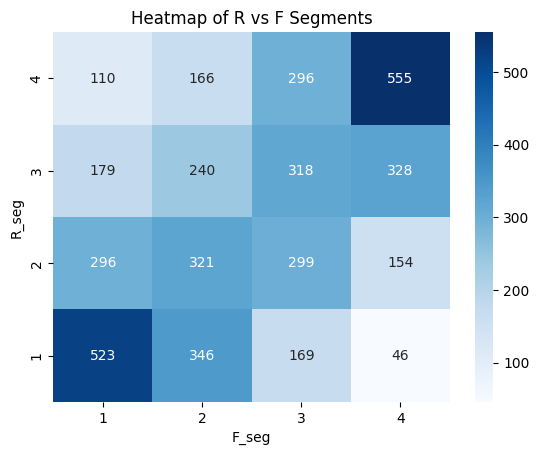

In [33]:
# Heatmap of RFM segments
rfm_pivot = df_rfm_seg_country.pivot_table(index='R_seg', columns='F_seg', values='CustomerID', aggfunc='count')
sns.heatmap(rfm_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Heatmap of R vs F Segments")
plt.show()


## Insights

- The largest customer group (555 customers) is in segment (R=4, F=4), indicating highly active and loyal customers who purchase both recently and frequently.

- A significant number of customers (523) fall into the (R=1, F=1) segment, representing those who purchased long ago and infrequently, potentially indicating churned or inactive customers.

- The middle segments (e.g., (R=3, F=3) and (R=2, F=2)) are also well-populated, suggesting a balanced mix of moderately engaged customers.

- Overall, the heatmap suggests that a substantial portion of the customer base is still highly engaged, while there’s also a clear opportunity to re-engage at-risk or inactive customers.

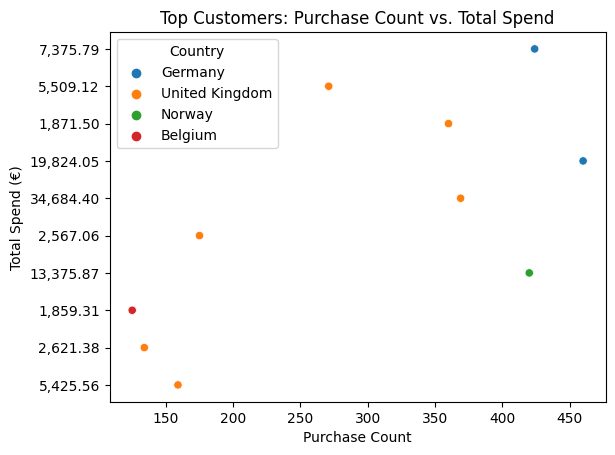

In [34]:
sns.scatterplot(data=top_customers, x='Purchase Count', y='Total Spend (€)', hue='Country')
plt.title("Top Customers: Purchase Count vs. Total Spend")
plt.show()

## Customer Churn analysis

In [35]:
churn_threshold = 90
df_rfm_seg_country['Churned'] = df_rfm_seg_country['Recency'] > churn_threshold

churn_summary = df_rfm_seg_country['Churned'].value_counts()
print("Churn Summary:\n", churn_summary)

churn_rate = df_rfm_seg_country['Churned'].mean()
print(f"Churn Rate: {churn_rate:.2%}")


Churn Summary:
 Churned
False    2900
True     1446
Name: count, dtype: int64
Churn Rate: 33.27%


In [36]:
top_churned = df_rfm_seg_country[df_rfm_seg_country['Churned'] == True].sort_values('Recency', ascending=False)
top_churned.head(10)

,CustomerID,Recency,Frequency,Monetary,R_seg,F_seg,M_seg,RFM_score,Country,Churned
4072,17908.0,373,58,243.28,1,3,1,5,United Kingdom,True
1757,14729.0,373,71,313.49,1,3,2,6,United Kingdom,True
4188,18074.0,373,13,489.60,1,1,2,4,United Kingdom,True
1045,13747.0,373,1,79.60,1,1,1,3,United Kingdom,True
4116,17968.0,373,85,277.35,1,3,1,5,United Kingdom,True
363,12791.0,373,2,192.60,1,1,1,3,Netherlands,True
3111,16583.0,373,14,233.45,1,1,1,3,United Kingdom,True
410,12855.0,372,3,38.10,1,1,1,3,United Kingdom,True
1999,15070.0,372,1,106.20,1,1,1,3,United Kingdom,True
2637,15923.0,372,21,127.08,1,2,1,4,United Kingdom,True


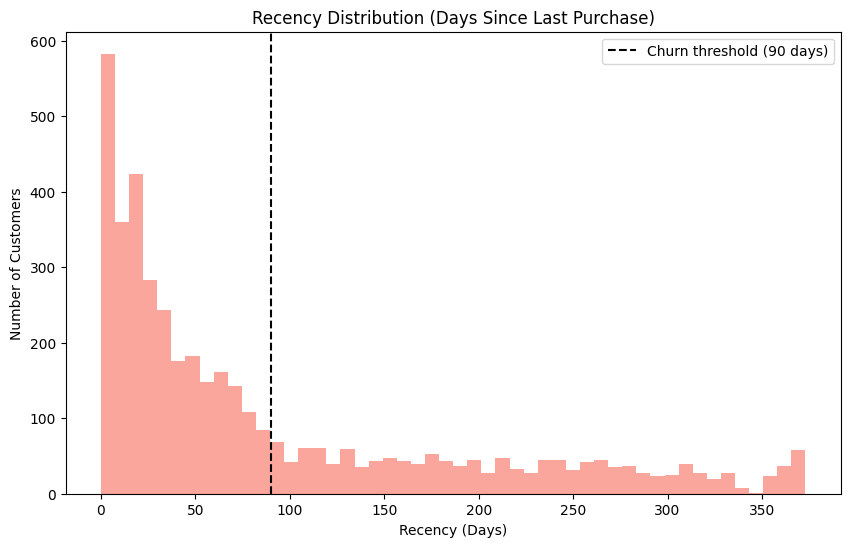

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_rfm_seg_country['Recency'], bins=50, color='salmon', alpha=0.7)
plt.axvline(churn_threshold, color='black', linestyle='--', label=f'Churn threshold ({churn_threshold} days)')
plt.title('Recency Distribution (Days Since Last Purchase)')
plt.xlabel('Recency (Days)')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()


## Customer characteristics and actionable recommendations

### Champions

Total RFM vlue >= 10

Characteristics: They are Recent buyers, purchase frequently, and spend the most

Suggested actions: Reward with exclusive perks, early product access, and VIP offers to increase retention.

### Loyal customers

Total RFM vlue >= 7

Characteristics: They are regular purchasers with strong spending history

Suggested actions: Promote cross-sell and upsell, offer loyalty points or tiered benefits.

### Potential loyalists

Total RFM vlue >= 4

Characteristics: They are recent buyers with moderate frequency and monetary value

Suggested actions: Nurture with personalized offers and encouragement to engage more frequently.

### At risk

Total RFM vlue < 4

Characteristics: They haven’t purchased in a while but used to spend well

Suggested actions: Re-engage with win-back campaigns, discounts, or surveys to understand churn.